In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [2]:
trainDF = pd.read_csv('train.csv')
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [3]:
testDF = pd.read_csv('test.csv')
testDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [4]:
concatDF = pd.concat([trainDF,testDF])
concatDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70000 entries, 0 to 27999
Columns: 785 entries, label to pixel783
dtypes: float64(1), int64(784)
memory usage: 419.8 MB


In [5]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, DF):
        if 'label' in DF.columns:
            self.label = pd.get_dummies(DF['label']).values
            DF = DF.drop(columns=['label'])
        self.data = DF.values/255
        pass

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x=self.data[idx].reshape(1,28,28)
        x=torch.FloatTensor(x)

        if hasattr(self,'label'):
            y=self.label[idx]
            y=torch.FloatTensor(y)

            return x, y
        else:
            return x

dataSet= MyDataset(DF=trainDF)
testSet = MyDataset(DF= testDF)
dataSet[0][1]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [6]:
splitSet = torch.utils.data.random_split(dataSet,(0.8,0.2))
splitSet

In [7]:
trainLoader=torch.utils.data.DataLoader(splitSet[0],batch_size=1024,sampler=torch.utils.data.RandomSampler(splitSet[0]))
valLoader=torch.utils.data.DataLoader(splitSet[1],batch_size=1024,sampler=torch.utils.data.RandomSampler(splitSet[1]))
testLoader = torch.utils.data.DataLoader(testSet,batch_size=1024)
trainLoader

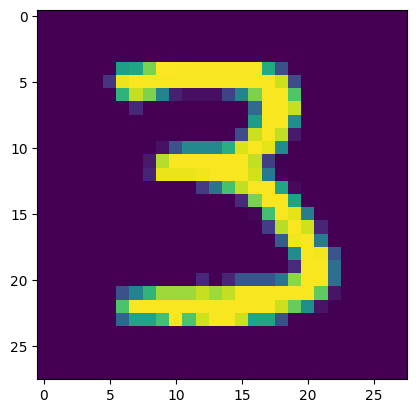

In [8]:
# get some random training images
dataiter = iter(trainLoader)
# images, labels = next(dataiter)
images, label = next(dataiter)

# show images
plt.imshow(images[0][0])

In [9]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.convStack = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, 3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Conv2d(1, 1, 3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Flatten(),
            torch.nn.Linear(25, 25),
            torch.nn.ReLU(),
            torch.nn.Linear(25, 10),
        )

    def forward(self, x):
        logits = self.convStack(x)
        return logits



model = Net().to(device)

Using mps device


In [10]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters())

In [11]:
def trainAI(dataLoader, model, loss_fn, optimizer):
    model.train()
    trainLoss=0
    for  X, y in dataLoader:
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        trainLoss +=loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    return trainLoss

In [12]:
def valAI(dataLoader, model, loss_fn,):
    model.eval()
    valLoss=0
    with torch.no_grad():
        for X,y in dataLoader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            valLoss+=loss.item()
    
    return valLoss

cnt: -1 - val loss: 20.8473961353302 - train loss: 76.37488412857056
cnt: 0 - val loss: 20.851682901382446 - train loss: 76.3619294166565
cnt: 0 - val loss: 20.82669496536255 - train loss: 76.34645676612854
cnt: 0 - val loss: 20.83600378036499 - train loss: 76.33375549316406
cnt: 1 - val loss: 20.819438457489014 - train loss: 76.31933259963989
cnt: 0 - val loss: 20.830579042434692 - train loss: 76.3043007850647
cnt: 1 - val loss: 20.81882333755493 - train loss: 76.29307556152344
cnt: 0 - val loss: 20.80320143699646 - train loss: 76.28252267837524
cnt: 0 - val loss: 20.813332557678223 - train loss: 76.26720547676086
cnt: 1 - val loss: 20.796043634414673 - train loss: 76.25598478317261
cnt: 0 - val loss: 20.81167697906494 - train loss: 76.24727845191956
cnt: 1 - val loss: 20.809003591537476 - train loss: 76.23648142814636
cnt: 2 - val loss: 20.79623794555664 - train loss: 76.22483420372009
cnt: 3 - val loss: 20.805533170700073 - train loss: 76.21270060539246
cnt: 4 - val loss: 20.7979505

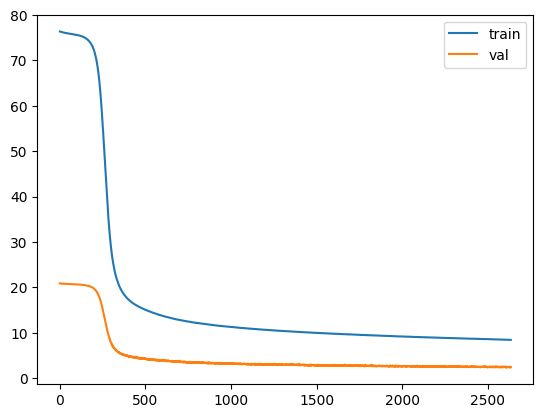

In [13]:
trainHistory,valHistory,=[],[]
previousLoss = float('inf')
cnt = -1
bestModel = model
while(cnt<100):
    trainLoss = trainAI(trainLoader, model, loss_fn, optimizer) 
    valLoss = valAI(valLoader, model, loss_fn)
    # scheduler.step()

    trainHistory.append(trainLoss)
    valHistory.append(valLoss)

    print(f'cnt: {cnt} - val loss: {valLoss} - train loss: {trainLoss}')

    if cnt<0 or previousLoss < valLoss:
        cnt +=1
    else:
        previousLoss = valLoss
        bestModel = model
        cnt =0 

plt.plot(trainHistory,label='train')
plt.plot(valHistory, label='val')
plt.legend() 

In [14]:
def testAI(dataloader, model):
    model.eval()
    out = []
    y=1
    with torch.no_grad():
        for X in dataloader:
            X  = X.to(device)
            pred = model(X)
            for i in pred:
                out.append([y, torch.argmax(i).item()])
                y+=1

    
    return out

result = testAI(testLoader, bestModel) 
# result = testAI(testLoader[0], model[0])
result

[[1, 2],
 [2, 0],
 [3, 8],
 [4, 7],
 [5, 2],
 [6, 7],
 [7, 0],
 [8, 3],
 [9, 0],
 [10, 3],
 [11, 5],
 [12, 7],
 [13, 3],
 [14, 0],
 [15, 4],
 [16, 3],
 [17, 3],
 [18, 1],
 [19, 9],
 [20, 0],
 [21, 9],
 [22, 1],
 [23, 1],
 [24, 5],
 [25, 7],
 [26, 4],
 [27, 2],
 [28, 7],
 [29, 9],
 [30, 7],
 [31, 7],
 [32, 2],
 [33, 4],
 [34, 2],
 [35, 6],
 [36, 2],
 [37, 0],
 [38, 5],
 [39, 1],
 [40, 6],
 [41, 7],
 [42, 7],
 [43, 4],
 [44, 9],
 [45, 8],
 [46, 7],
 [47, 8],
 [48, 2],
 [49, 8],
 [50, 7],
 [51, 6],
 [52, 8],
 [53, 8],
 [54, 3],
 [55, 8],
 [56, 2],
 [57, 1],
 [58, 2],
 [59, 2],
 [60, 5],
 [61, 4],
 [62, 1],
 [63, 7],
 [64, 0],
 [65, 0],
 [66, 0],
 [67, 1],
 [68, 9],
 [69, 0],
 [70, 1],
 [71, 6],
 [72, 5],
 [73, 8],
 [74, 8],
 [75, 2],
 [76, 8],
 [77, 3],
 [78, 9],
 [79, 2],
 [80, 3],
 [81, 5],
 [82, 9],
 [83, 1],
 [84, 0],
 [85, 9],
 [86, 2],
 [87, 4],
 [88, 3],
 [89, 6],
 [90, 7],
 [91, 2],
 [92, 0],
 [93, 6],
 [94, 6],
 [95, 1],
 [96, 4],
 [97, 3],
 [98, 9],
 [99, 7],
 [100, 4],
 [101, 0

In [15]:
outDF= pd.DataFrame(result)
outDF= outDF.astype(int)
outDF.columns=['ImageId','Label']
outDF

,ImageId,Label
0,1,2
1,2,0
2,3,8
3,4,7
4,5,2
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [16]:
outDF.to_csv('result.csv',index=False)